# AIoT Project

In [1]:
#pip install -r requirements.txt

In [2]:
import os

# basic data engineering
import pandas as pd
import numpy as np
import scipy

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# db
import pymongo

# configs & other
import yaml
from tqdm.notebook import tqdm_notebook
from datetime import datetime
from time import time

from psynlig import pca_explained_variance_bar

# utils processing
from utils import sliding_window_pd
from utils import apply_filter
from utils import filter_instances
from utils import flatten_instances_df
from utils import df_rebase
from utils import rename_df_column_values
from utils import list_files_in_folder

# utils visualization
from utils_visual import plot_instance_time_domain
from utils_visual import plot_instance_3d
from utils_visual import plot_np_instance
from utils_visual import plot_heatmap
from utils_visual import plot_scatter_pca

%load_ext autoreload
%autoreload 2

Start time of execution

In [3]:
time_start = time()

## Load configuration

In [4]:
config_path = os.path.join(os.getcwd(), "config.yml")

with open(config_path) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [5]:
client = pymongo.MongoClient(config["client"])

In [6]:
db = client[config["db"]]
coll = db[config["col"]]

In [7]:
found_keys = coll.distinct("label")
print("Existing DB keys:", found_keys)

Existing DB keys: ['A', 'L']


## Load data

In [8]:
data_A = []
data_L = []

for doc in coll.find():
    # Set to the proper format of data
    formatted = {
        "data": {
            "acc_x": doc.get("acc_x", []),
            "acc_y": doc.get("acc_y", []),
            "acc_z": doc.get("acc_z", [])
        },
        "label": doc.get("label", ""),
        "datetime": doc.get("datetime", datetime.now())
    }

    if formatted["label"] == "A":
        data_A.append(formatted)
    elif formatted["label"] == "L":
        data_L.append(formatted)

# Print the entries
print(f"Loaded {len(data_A)} entries for class A")
print(f"Loaded {len(data_L)} entries for class L")

Loaded 13004 entries for class A
Loaded 10309 entries for class L


In [9]:
df_A = pd.DataFrame(data_A)
df_L = pd.DataFrame(data_L)

# Data in proper format
df_A_flat = pd.concat([pd.json_normalize(df_A['data']), df_A.drop(columns=['data'])], axis=1)
df_L_flat = pd.concat([pd.json_normalize(df_L['data']), df_L.drop(columns=['data'])], axis=1)

print(df_A_flat.head(10))
print(df_L_flat.head(10))

      acc_x     acc_y     acc_z label                   datetime
0  0.171997 -0.335999  0.270935     A 2025-05-27 16:03:56.541662
1  0.079224 -0.321716  0.204529     A 2025-05-27 16:03:56.541670
2  0.055908 -0.307739  0.149658     A 2025-05-27 16:03:56.541673
3  0.067993 -0.318787  0.125000     A 2025-05-27 16:03:56.541675
4  0.075500 -0.350525  0.124207     A 2025-05-27 16:03:56.541677
5  0.053894 -0.430054  0.146423     A 2025-05-27 16:03:56.541679
6  0.074341 -0.517151  0.217896     A 2025-05-27 16:03:56.541681
7  0.167053 -0.549194  0.299194     A 2025-05-27 16:03:56.541687
8  0.271301 -0.599182  0.331665     A 2025-05-27 16:03:56.541690
9  0.334900 -0.678284  0.373169     A 2025-05-27 16:03:56.541692
      acc_x     acc_y     acc_z label                   datetime
0  0.038818 -0.205872  0.080811     L 2025-05-27 16:03:56.643300
1  0.004272 -0.308105  0.091370     L 2025-05-27 16:03:56.643307
2 -0.011047 -0.408813  0.077820     L 2025-05-27 16:03:56.643309
3  0.001282 -0.468262  0.

## Explore the nature of the data

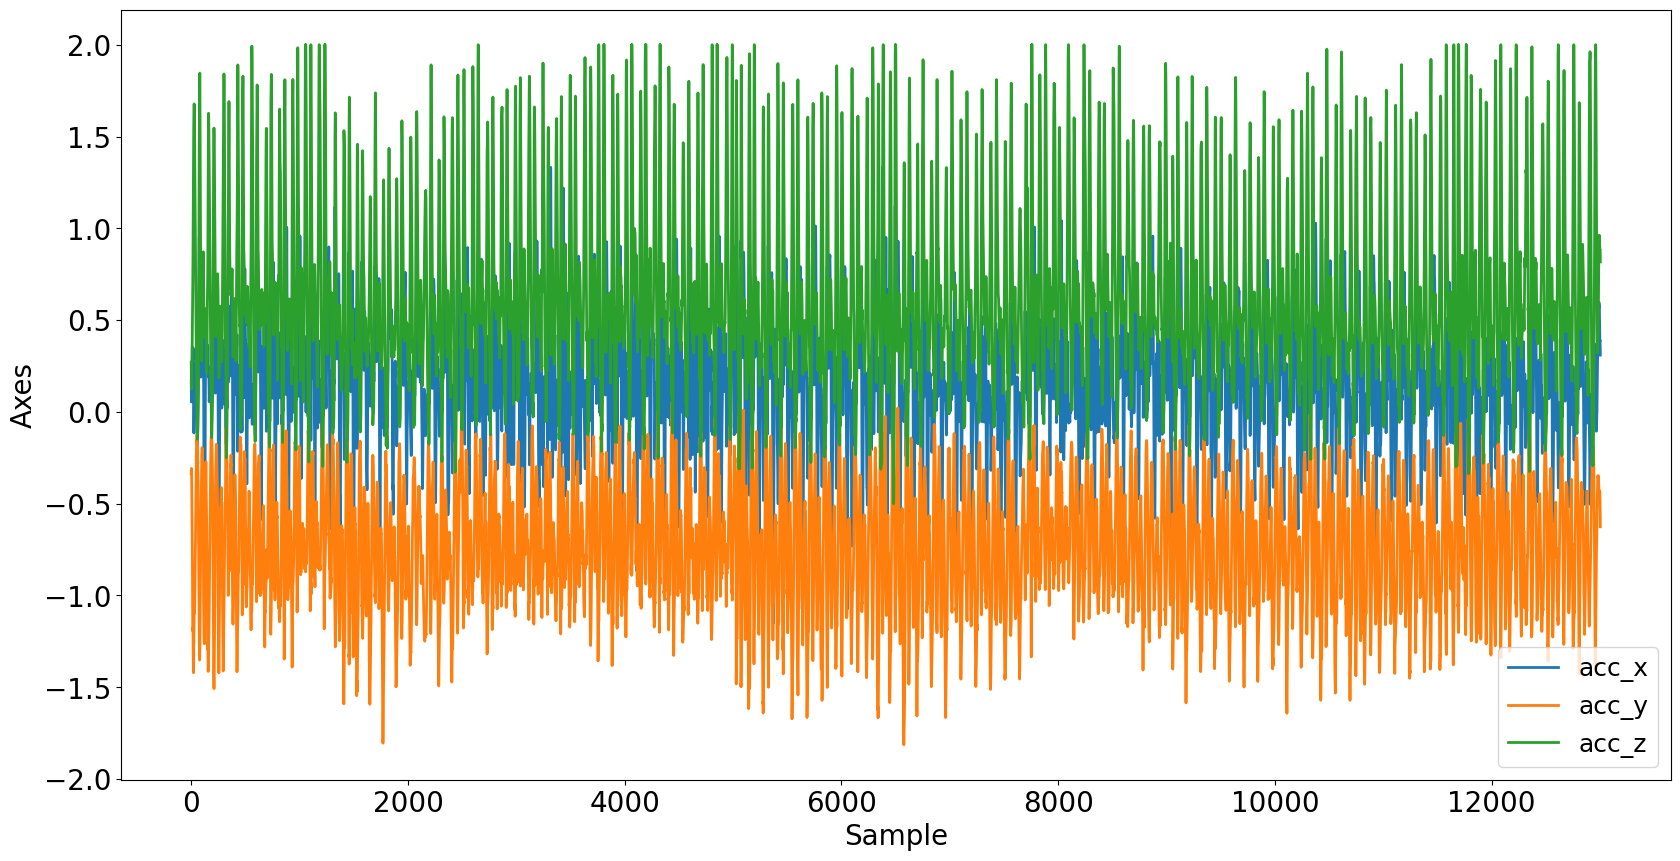

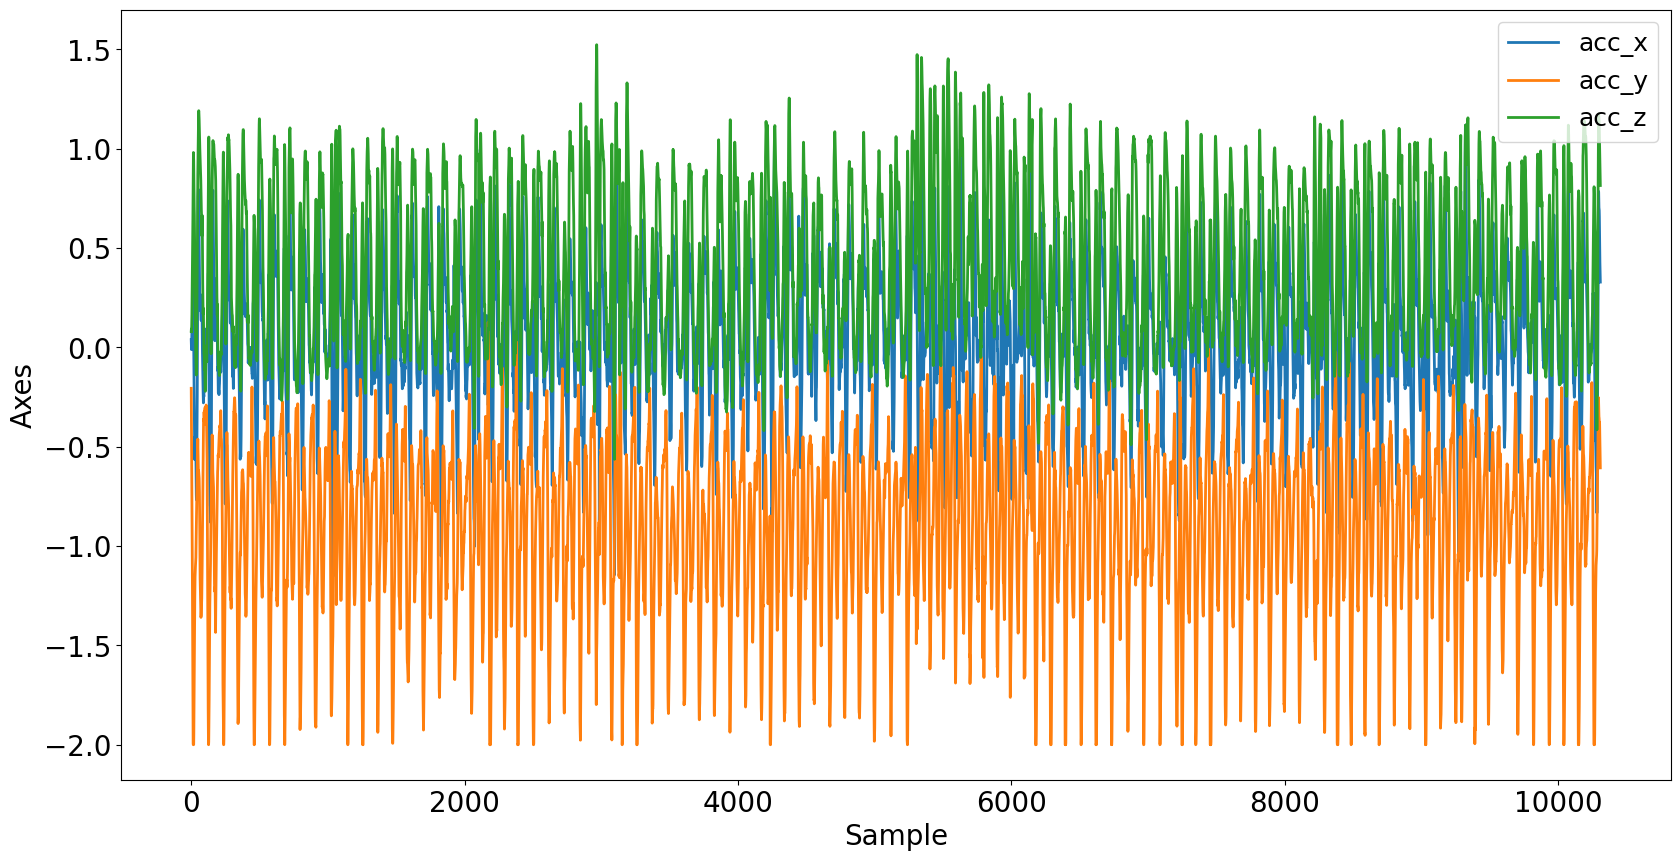

In [10]:
# Plot the data of each class
plot_instance_time_domain(df_A_flat[['acc_x', 'acc_y', 'acc_z']])
plot_instance_time_domain(df_L_flat[['acc_x', 'acc_y', 'acc_z']])

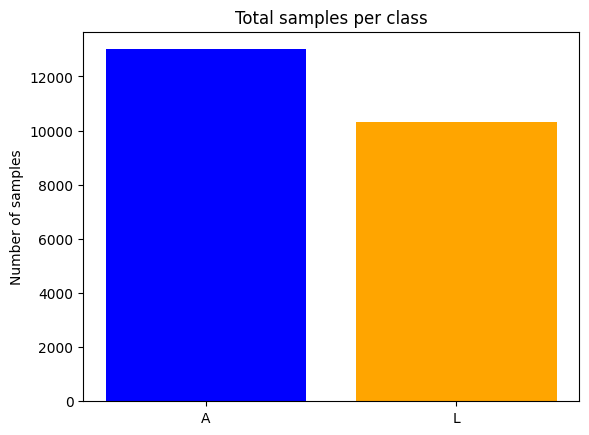

In [11]:
# Plot total samples for each class
lengths = [len(df_A_flat), len(df_L_flat)]
classes = ['A', 'L']

plt.bar(classes, lengths, color=['blue', 'orange'])
plt.ylabel('Number of samples')
plt.title('Total samples per class')
plt.show()

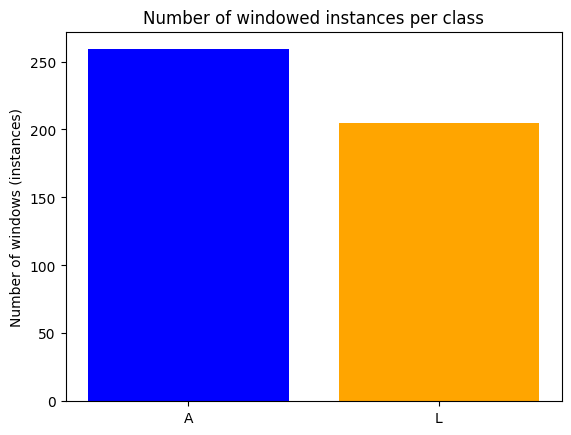

In [12]:
# Windowing
windows_A = sliding_window_pd(df_A_flat[['acc_x', 'acc_y', 'acc_z']])
windows_L = sliding_window_pd(df_L_flat[['acc_x', 'acc_y', 'acc_z']])

counts = [len(windows_A), len(windows_L)]

# Plot the windows for each class
plt.bar(classes, counts, color=['blue', 'orange'])
plt.ylabel('Number of windows (instances)')
plt.title('Number of windowed instances per class')
plt.show()

## Apply filter

In [13]:
filtered_A = filter_instances(windows_A)
filtered_L = filter_instances(windows_L)

Number of filtered instances in the list: 259
Number of filtered instances in the list: 205


In [42]:
"""
# Print just for verification that the filter applied to the signal

print(f"Number of windows for class A: {len(windows_A)}")
print(f"Number of windows for class L: {len(windows_L)}")

# Print shape info of first window for each class
if windows_A:
    print("First window A shape:", windows_A[0].shape)
if windows_L:
    print("First window L shape:", windows_L[0].shape)

# Print example values from first window before filtering (class A)
if windows_A:
    print("\nFirst window (class A) first 5 rows before filtering:")
    print(windows_A[0].head())

# Print example values from first window after filtering (class A)
if filtered_A:
    print("\nFirst filtered window (class A) first 5 rows:")
    print(filtered_A[0].head())

# Print example values from first window before filtering (class L)
if windows_L:
    print("\nFirst window (class L) first 5 rows before filtering:")
    print(windows_L[0].head())

# Print example values from first window after filtering (class L)
if filtered_L:
    print("\nFirst filtered window (class L) first 5 rows:")
    print(filtered_L[0].head
    
"""

'\n# Print just for verification that the filter applied to the signal\n\nprint(f"Number of windows for class A: {len(windows_A)}")\nprint(f"Number of windows for class L: {len(windows_L)}")\n\n# Print shape info of first window for each class\nif windows_A:\n    print("First window A shape:", windows_A[0].shape)\nif windows_L:\n    print("First window L shape:", windows_L[0].shape)\n\n# Print example values from first window before filtering (class A)\nif windows_A:\n    print("\nFirst window (class A) first 5 rows before filtering:")\n    print(windows_A[0].head())\n\n# Print example values from first window after filtering (class A)\nif filtered_A:\n    print("\nFirst filtered window (class A) first 5 rows:")\n    print(filtered_A[0].head())\n\n# Print example values from first window before filtering (class L)\nif windows_L:\n    print("\nFirst window (class L) first 5 rows before filtering:")\n    print(windows_L[0].head())\n\n# Print example values from first window after filteri

3D plot for first filtered window of class A


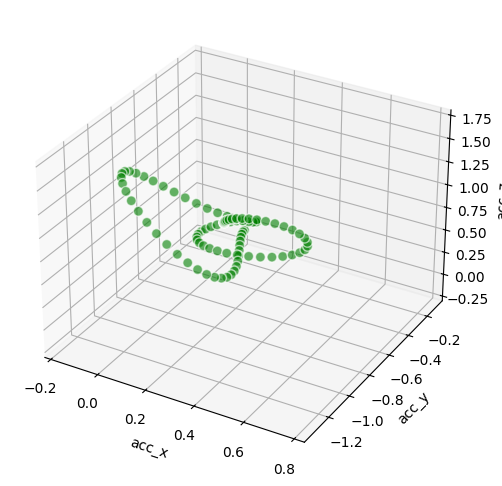

3D plot for first filtered window of class L


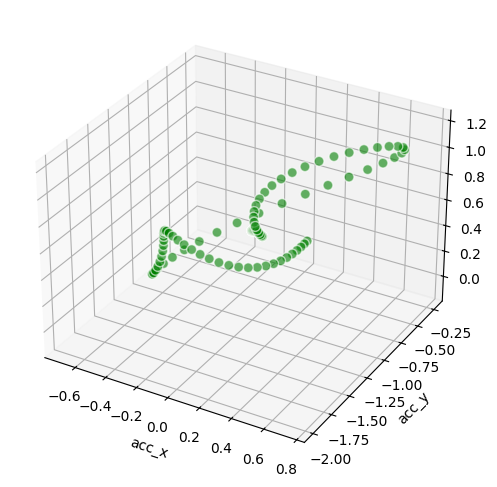

In [15]:
# Plot 3d
if filtered_A:
    print("3D plot for first filtered window of class A")
    plot_instance_3d(filtered_A[0])
    plt.show()

if filtered_L:
    print("3D plot for first filtered window of class L")
    plot_instance_3d(filtered_L[0])
    plt.show()

## Transform the list of DataFrames to NumPy array

Transform the list of DataFrames to NumPy array that contains the windows: (instances, x, y)

In [16]:
X_A = np.array([df.to_numpy() for df in windows_A])
print("Shape of X_A (instances x samples x features):", X_A.shape)

X_L = np.array([df.to_numpy() for df in windows_L])
print("Shape of X_L (instances x samples x features):", X_L.shape)

Shape of X_A (instances x samples x features): (259, 100, 3)
Shape of X_L (instances x samples x features): (205, 100, 3)


## Flatten the 2D window instances

Flatten the X NumPy array that contains the 2D window instances


Flattened filtered data for class A shape: (259, 300)
Flattened filtered data for class L shape: (205, 300)


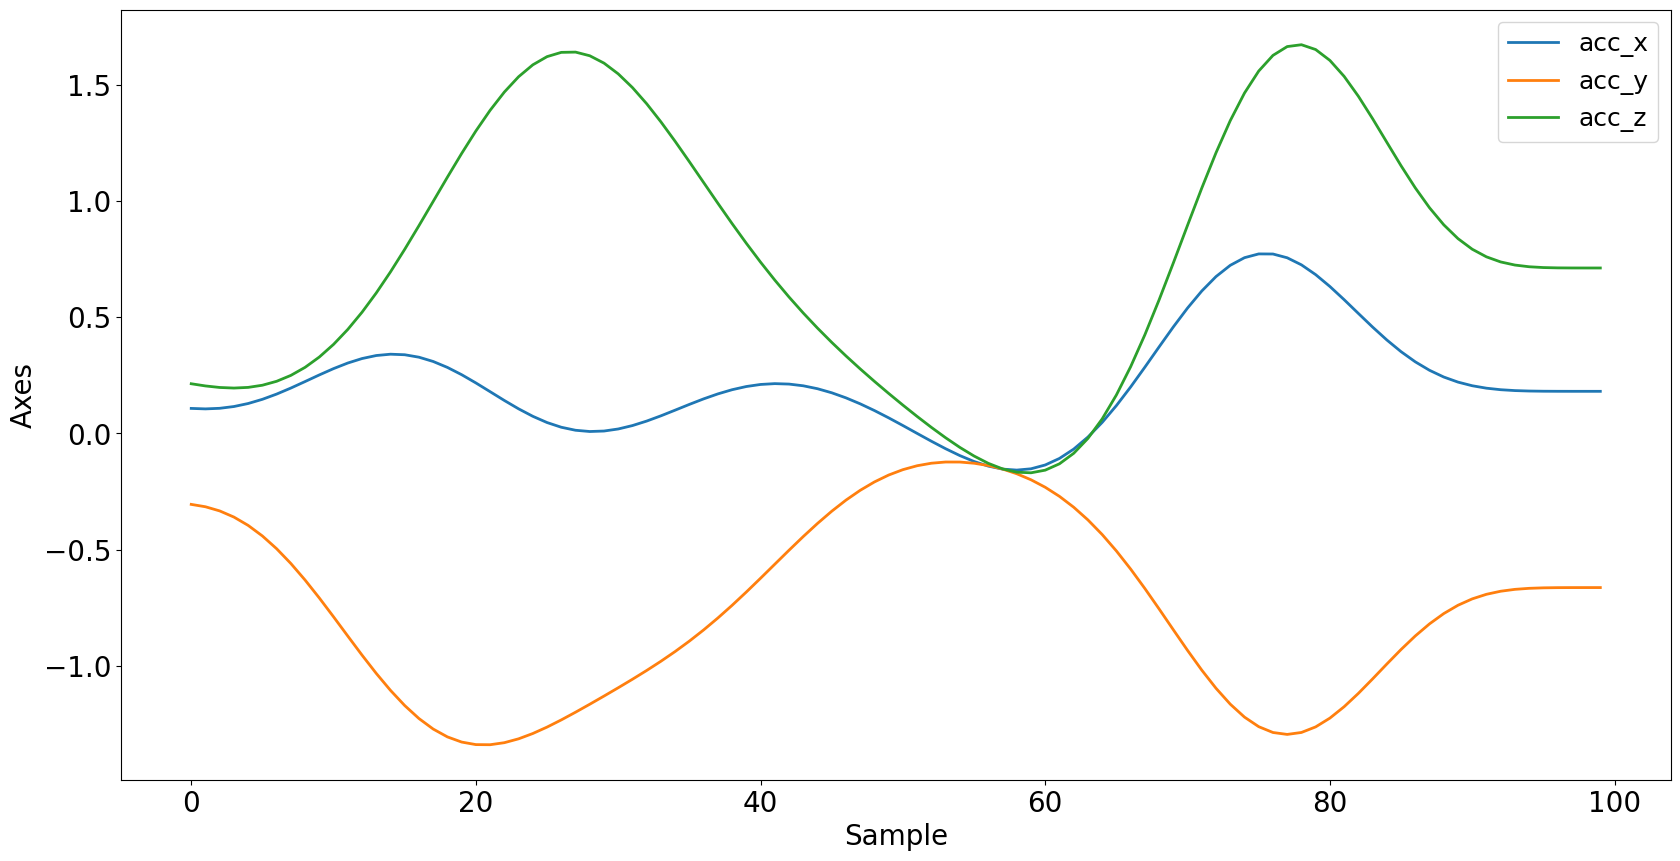

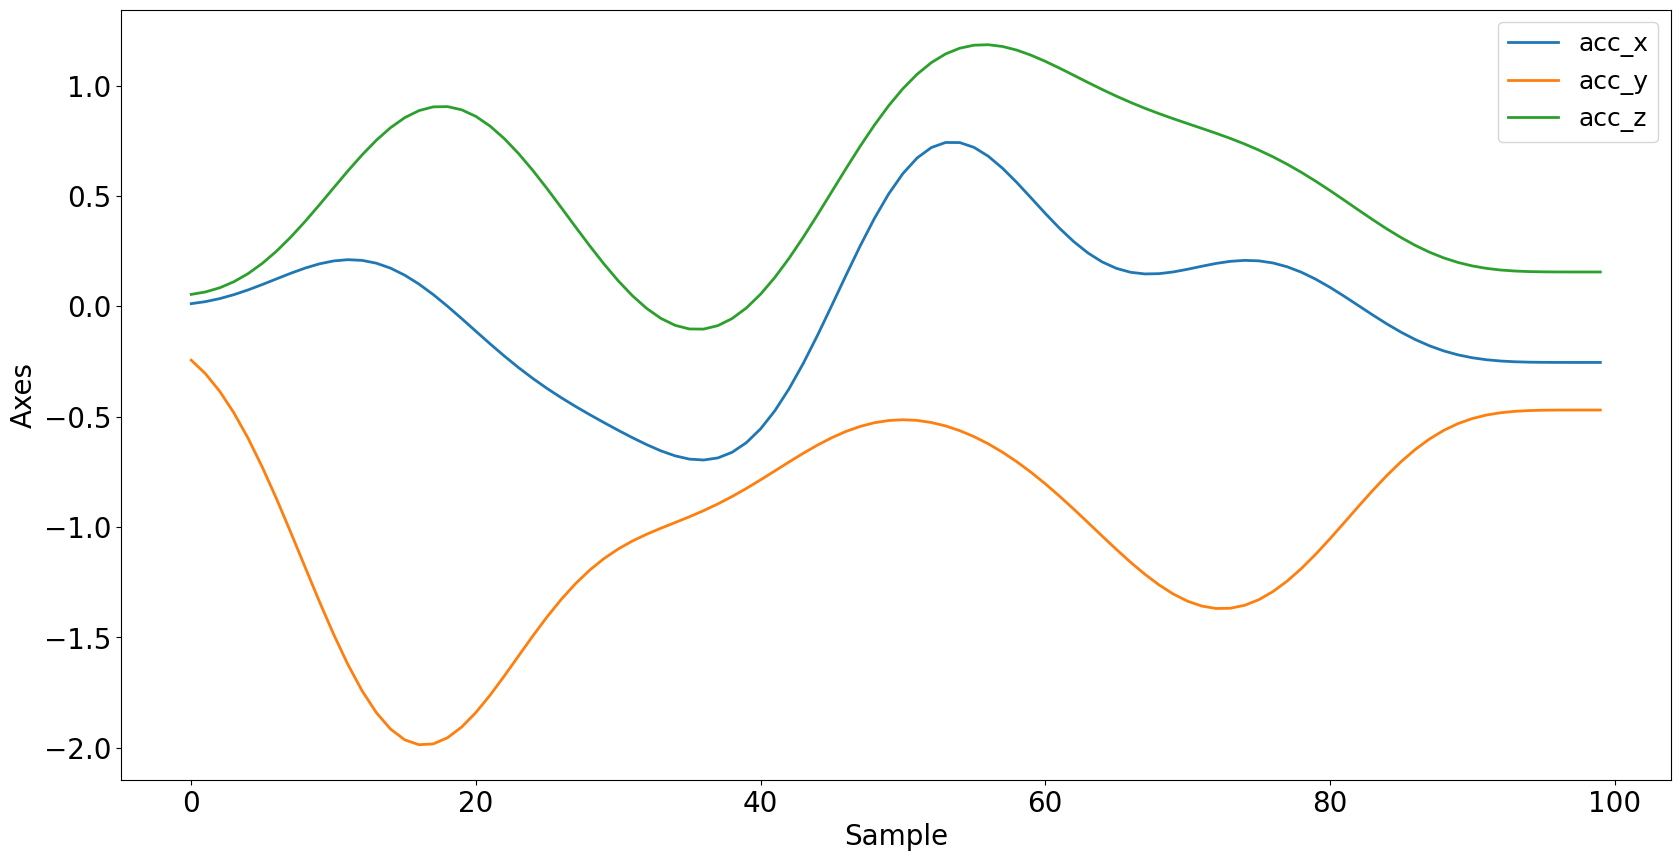

In [17]:
df_filtered_A_flat = flatten_instances_df(filtered_A)
print(f"\nFlattened filtered data for class A shape: {df_filtered_A_flat.shape}")

df_filtered_L_flat = flatten_instances_df(filtered_L)
print(f"Flattened filtered data for class L shape: {df_filtered_L_flat.shape}")

# Plot 1st filtered window for each class
plot_instance_time_domain(filtered_A[0][['acc_x', 'acc_y', 'acc_z']])
plot_instance_time_domain(filtered_L[0][['acc_x', 'acc_y', 'acc_z']])

## Train/Test split

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
X = np.vstack((df_filtered_A_flat, df_filtered_L_flat))

# Create corresponding labels: 0 for 'A', 1 for 'L'
y = [0] * len(df_filtered_A_flat) + [1] * len(df_filtered_L_flat)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=42)

In [21]:
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Training samples: 371
Test samples: 93


## Scaling

In [22]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [23]:
scaler = MinMaxScaler()

# Scale test and train sets
print(X_train.shape)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Min-Max normalization done.")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

(371, 300)
Min-Max normalization done.
X_train_scaled shape: (371, 300)
X_test_scaled shape: (93, 300)


## Transform to 2D again

In [24]:
window_size = 100  # your window size
num_features = 3   # acc_x, acc_y, acc_z

# For train set
X_train_reshaped = X_train_scaled.reshape(-1, window_size, num_features)

# For test set
X_test_reshaped = X_test_scaled.reshape(-1, window_size, num_features)
 
print("Train shape after reshape:", X_train_reshaped.shape)
print("Test shape after reshape:", X_test_reshaped.shape)

Train shape after reshape: (371, 100, 3)
Test shape after reshape: (93, 100, 3)


## Dimensionality Reduction with PCA using the 1D (flattened) data

In [25]:
# add transformers
from sklearn.decomposition import PCA

In [26]:
# Choose how many components you want to keep
n_components = 2  # for example, reduce to 10 principal components

pca = PCA(n_components=n_components)

# Fit PCA on the training data and transform both train and test sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

Shape of X_train after PCA: (371, 2)
Shape of X_test after PCA: (93, 2)


### PCA with 2 Components

In [27]:
pca.fit(X_train_pca)

PCA(n_components=2)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Principal component', ylabel='Explained variance (fraction) per component'>)

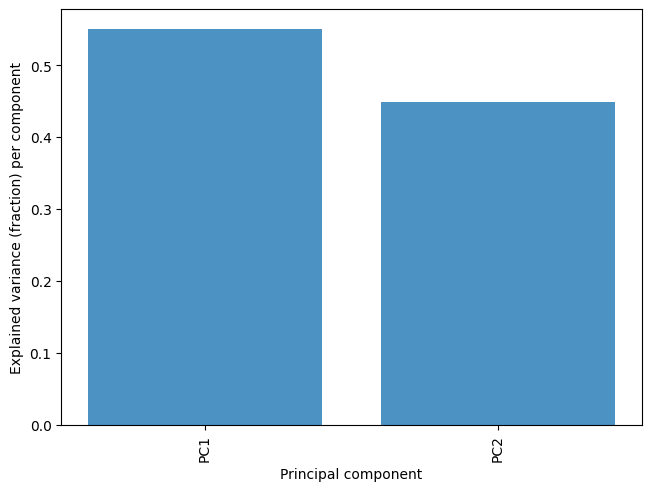

In [28]:
pca_explained_variance_bar(pca, alpha=0.8)

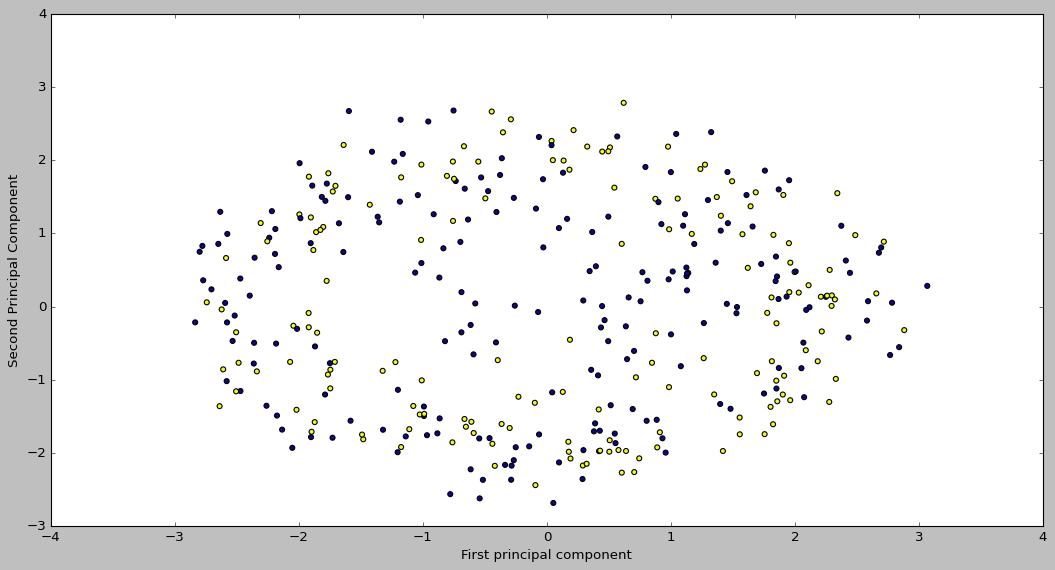

In [29]:
# Convert to DataFrame and add labels
df_pca = pd.DataFrame(X_train_pca, columns=["PC1", "PC2"])
df_pca["label"] = y_train

plot_scatter_pca(df_pca, c_name="label")

### PCA with 3 Components

Shape of X_train after PCA: (371, 3)
Shape of X_test after PCA: (93, 3)


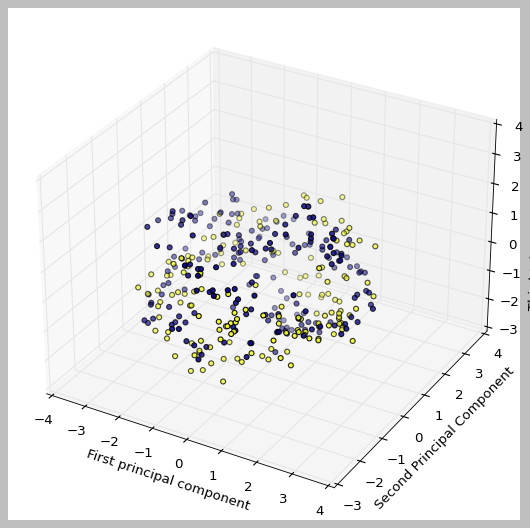

In [30]:
n_components = 3

pca = PCA(n_components=n_components)

# Apply PCA on train data
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

df_pca_3d = pd.DataFrame(X_train_pca, columns=["PC1", "PC2", "PC3"])

# Add label column
df_pca_3d["label"] = y_train
plot_scatter_pca(df_pca_3d, c_name="label")

### PCA with X% of the variance of the dataset, for training the statistical AI Models

In [31]:
# Keep 95% of the total variance
pca = PCA(n_components=0.95)

# Apply PCA on train data and transform both sets
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Shape of X_train after PCA:", X_train_pca.shape)
print("Shape of X_test after PCA:", X_test_pca.shape)

Shape of X_train after PCA: (371, 16)
Shape of X_test after PCA: (93, 16)


## Classifier - Statistical Learning

### Apply simple classifier

In [32]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [33]:
# Use LogisticRegression 
clf = LogisticRegression(random_state=42)
clf.fit(X_train_pca, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_pca)

### Evaluate simple classifier

Accuracy: 0.9892

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        43

    accuracy                           0.99        93
   macro avg       0.99      0.99      0.99        93
weighted avg       0.99      0.99      0.99        93



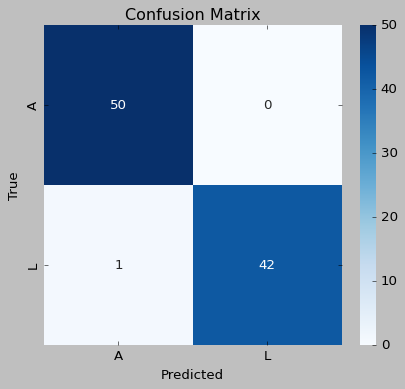

In [34]:
# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "L"], yticklabels=["A", "L"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Apply optimization with Grid Search and Cross-validation

In [35]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.9892

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        43

    accuracy                           0.99        93
   macro avg       0.99      0.99      0.99        93
weighted avg       0.99      0.99      0.99        93



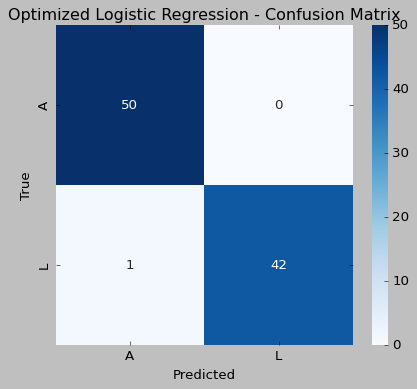

In [36]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        
    'penalty': ['l1', 'l2'],             
    'solver': ['liblinear']              
}

# Initialize GridSearchCV with cross-validation
grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='accuracy',    # Optimization metric
    n_jobs=-1              # Use all available cores
)

# Fit the grid search on training PCA data
grid.fit(X_train_pca, y_train)

# Best parameters and model
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "L"], yticklabels=["A", "L"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Optimized Logistic Regression - Confusion Matrix")
plt.show()

### Evaluate optimized classifier

Best Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Test Accuracy: 0.9892

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        43

    accuracy                           0.99        93
   macro avg       0.99      0.99      0.99        93
weighted avg       0.99      0.99      0.99        93



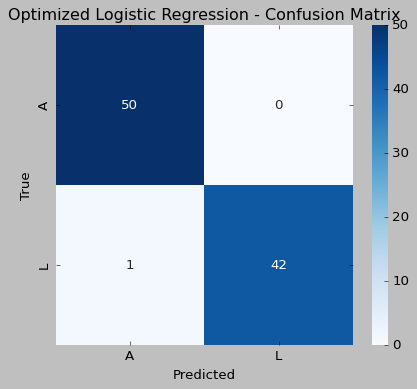

In [37]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],        # Inverse of regularization strength
    'penalty': ['l1', 'l2'],             # Regularization type
    'solver': ['liblinear']              # Supports both l1 and l2
}

# Initialize GridSearchCV with cross-validation
grid = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid,
    cv=5,                  # 5-fold cross-validation
    scoring='accuracy',    # Optimization metric
    n_jobs=-1              # Use all available cores
)

# Apply the grid search on training PCA data
grid.fit(X_train_pca, y_train)

# Best parameters and model
print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test_pca)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["A", "L"], yticklabels=["A", "L"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Optimized Logistic Regression - Confusion Matrix")
plt.show()

## Classifier - Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten

2025-05-27 16:04:13.110280: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 16:04:13.162590: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 16:04:13.162641: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 16:04:13.162708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 16:04:13.186447: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 16:04:13.189179: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [39]:
input_data_shape = X_train_2d[0].shape
print("Type of the input shape object:", type(input_data_shape))
X_train_2d[0].shape

NameError: name 'X_train_2d' is not defined

In [ ]:
y_np_array = np.array(y)
n_outputs = len(np.unique(y_np_array))
print("Number of outputs (classes) the model to predict:", n_outputs)

### Create the Neural Network (NN) Architecture and instantiate the model

In [ ]:
model = Sequential()

"""
BUILD YOUR MODEL ARCHITECTURE HERE
"""

model.add(Dense(n_outputs, activation="softmax"))

Plot the Architecture of ot the TensorFlow model

Plot the summary of the TensorFlow model

### Build the NN model

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["ADD METRIC"])

In [ ]:
from utils import encode_labels

### Train the NN model

### Evaluate the model on the test data

### Plot and interpret the learning curves: Loss and Accuracy based on the training and validation sets